In [59]:
from src.utils.tools import Tools
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
import os

In [60]:
# high-level directory to search
root_dir = "data/cache/predictions/scores"

# find all .jsonl files recursively
file_paths = glob.glob(os.path.join(root_dir, "**", "*.jsonl"), recursive=True)

# load and merge all lines from all score files
all_lines = []
for path in file_paths:
    all_lines.extend(Tools.load_jsonl(path))


# create full_df
records = []
for line in all_lines:
    for repo, samples in line["repos"].items():
        for test_number, sample in enumerate(samples, start=1):
            records.append(
                {
                    "benchmark": line["benchmark"],
                    "mode": line["mode"],
                    "repo": repo,
                    "em_score": sample["em_score"],
                    "es_score": sample["es_score"],
                    "test_number": test_number,
                }
            )

full_df = pd.DataFrame.from_records(records)

for col in ["benchmark", "mode", "repo"]:
    print(f"{col}:", full_df[col].unique())

benchmark: ['short_api' 'short_line']
mode: ['rag' 'gt' 'no-rag']
repo: ['huggingface_diffusers' 'nerfstudio-project_nerfstudio' 'awslabs_fortuna'
 'huggingface_evaluate' 'google_vizier' 'alibaba_FederatedScope'
 'pytorch_rl' 'opendilab_ACE']


In [61]:
def create_repo_agg_df(df, exclude_gt):
    filtered_df = df.copy()
    if exclude_gt:
        filtered_df = filtered_df[filtered_df["mode"] != "gt"]

    agg_df = filtered_df.groupby(["benchmark", "repo", "mode"]).agg(
        {"em_score": ["mean"], "es_score": ["mean"]}
    )
    agg_df.columns = ["_".join(col).strip() for col in agg_df.columns.values]
    agg_df = agg_df.reset_index()
    return agg_df


def plot_repo_metrics(df, exclude_gt=True):
    agg_df = create_repo_agg_df(df, exclude_gt)

    agg_df = agg_df.sort_values(by=["benchmark", "repo", "mode"])
    benchmarks = agg_df["benchmark"].unique()
    modes = agg_df["mode"].unique()
    num_benchmarks = len(benchmarks)

    fig, axes = plt.subplots(
        nrows=num_benchmarks, ncols=2, figsize=(14, 5 * num_benchmarks), sharey="row"
    )

    if num_benchmarks == 1:
        axes = [axes]

    width = 0.8 / len(modes)
    colors = plt.cm.Set1.colors

    for i, benchmark in enumerate(benchmarks):
        df_bench = agg_df[agg_df["benchmark"] == benchmark]
        repos = df_bench["repo"].unique()
        x = np.arange(len(repos))

        # Plot EM score
        ax_em = axes[i][0]
        for j, mode in enumerate(modes):
            df_mode = df_bench[df_bench["mode"] == mode]
            em_scores = df_mode.set_index("repo").reindex(repos)["em_score_mean"]
            ax_em.bar(
                x + j * width - width * (len(modes) - 1) / 2,
                em_scores,
                width=width,
                label=mode,
                color=colors[j],
                edgecolor="black",
                linewidth=0.8,
            )
        ax_em.set_title(f"{benchmark.replace('_', ' ').title()} - Exact Match Score")
        ax_em.set_ylabel("Score")
        ax_em.set_ylim(0, 1)
        ax_em.set_xticks(x)
        ax_em.set_xticklabels(repos, rotation=45, ha="right")

        # Plot ES score
        ax_es = axes[i][1]
        for j, mode in enumerate(modes):
            df_mode = df_bench[df_bench["mode"] == mode]
            es_scores = df_mode.set_index("repo").reindex(repos)["es_score_mean"]
            ax_es.bar(
                x + j * width - width * (len(modes) - 1) / 2,
                es_scores,
                width=width,
                label=mode,
                color=colors[j],
                edgecolor="black",
                linewidth=0.8,
            )
        ax_es.set_title(f"{benchmark.replace('_', ' ').title()} - Edit Similarity Score")
        ax_es.set_ylim(0, 1)
        ax_es.set_xticks(x)
        ax_es.set_xticklabels(repos, rotation=45, ha="right")

        if i == 0:
            ax_em.legend(title="Mode", loc="upper left")

    plt.tight_layout()
    plt.show()

    display(agg_df)
    return agg_df

In [62]:
def create_agg_df(df, exclude_gt):
    filtered_df = df.copy()
    if exclude_gt:
        filtered_df = filtered_df[filtered_df["mode"] != "gt"]

    agg_df = filtered_df.groupby(["benchmark", "mode"]).agg(
        {"em_score": ["mean"], "es_score": ["mean"]}
    )
    agg_df.columns = ["_".join(col).strip() for col in agg_df.columns.values]
    agg_df = agg_df.reset_index()
    return agg_df


def plot_agg_metrics(df, exclude_gt=True):
    agg_df = create_agg_df(df, exclude_gt)
    agg_df = agg_df.sort_values(by=["benchmark", "mode"])

    benchmarks = agg_df["benchmark"].unique()
    modes = agg_df["mode"].unique()
    x = np.arange(len(benchmarks))
    width = 0.8 / len(modes)
    colors = plt.cm.Set1.colors

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), sharex=True)

    # EM score plot
    ax_em = axes[0]
    for j, mode in enumerate(modes):
        df_mode = agg_df[agg_df["mode"] == mode].set_index("benchmark").reindex(benchmarks)
        em_scores = df_mode["em_score_mean"]
        ax_em.bar(
            x + j * width - width * (len(modes) - 1) / 2,
            em_scores,
            width=width,
            label=mode,
            color=colors[j],
            edgecolor="black",
            linewidth=0.8,
        )
    ax_em.set_title("Exact Match Score by Benchmark")
    ax_em.set_ylabel("EM Score")
    ax_em.set_ylim(0, 1)

    # ES score plot
    ax_es = axes[1]
    for j, mode in enumerate(modes):
        df_mode = agg_df[agg_df["mode"] == mode].set_index("benchmark").reindex(benchmarks)
        es_scores = df_mode["es_score_mean"]
        ax_es.bar(
            x + j * width - width * (len(modes) - 1) / 2,
            es_scores,
            width=width,
            label=mode,
            color=colors[j],
            edgecolor="black",
            linewidth=0.8,
        )
    ax_es.set_title("Edit Similarity Score by Benchmark")
    ax_es.set_ylabel("ES Score")
    ax_es.set_ylim(0, 1)
    ax_es.set_xticks(x)
    ax_es.set_xticklabels(benchmarks, ha="right")

    # Add legend once
    axes[0].legend(title="Mode", loc="upper left")

    plt.tight_layout()
    plt.show()

    display(agg_df)
    return agg_df

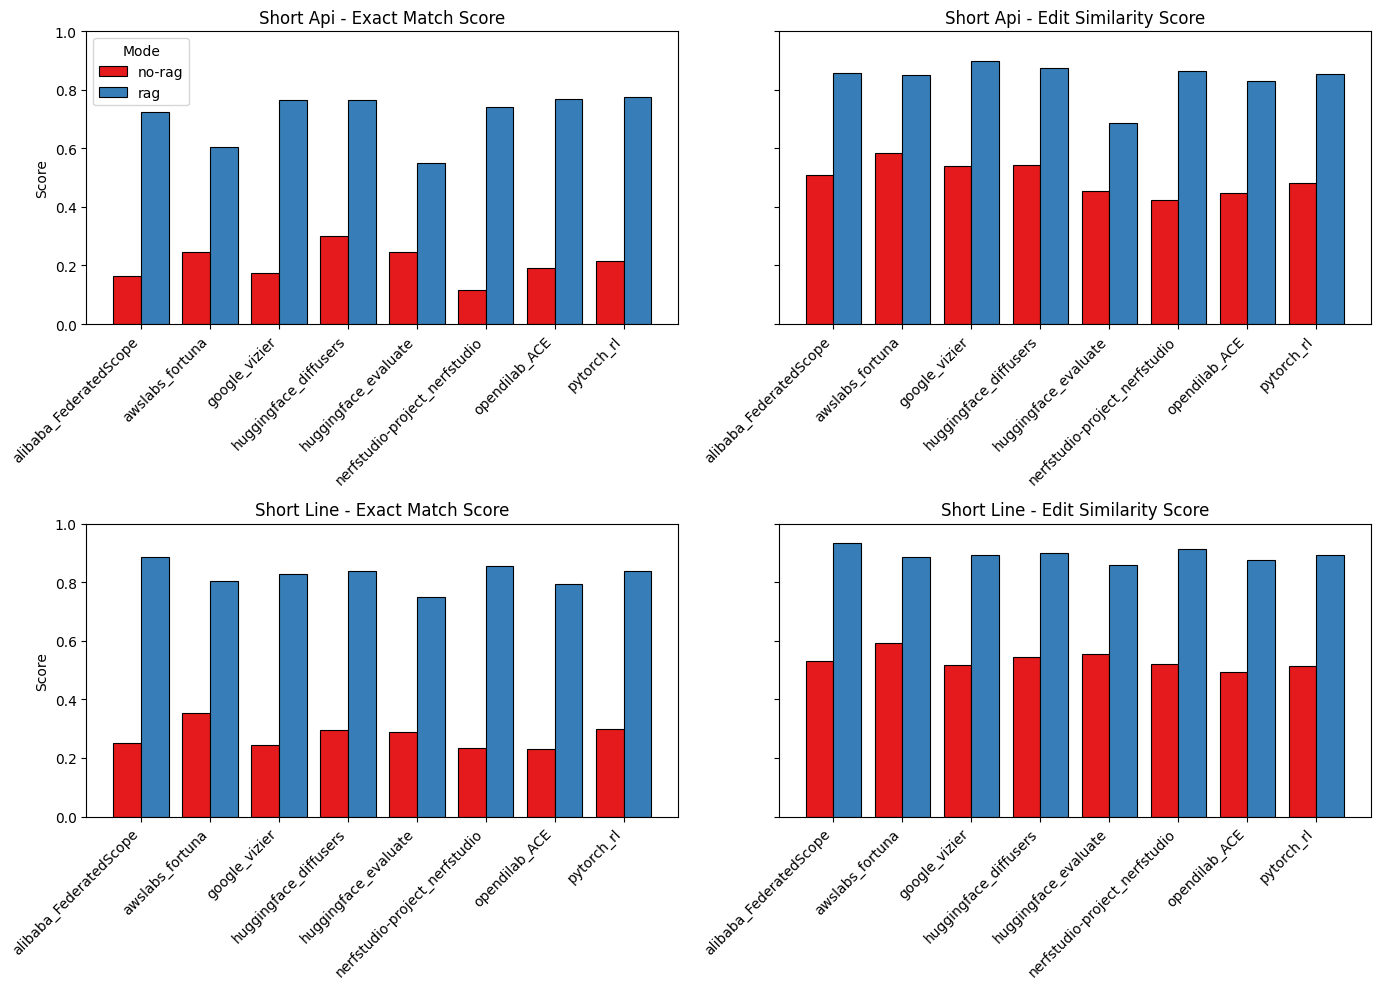

,benchmark,repo,mode,em_score_mean,es_score_mean
0,short_api,alibaba_FederatedScope,no-rag,0.165,0.510062
1,short_api,alibaba_FederatedScope,rag,0.725,0.859044
2,short_api,awslabs_fortuna,no-rag,0.245,0.582655
3,short_api,awslabs_fortuna,rag,0.605,0.849808
4,short_api,google_vizier,no-rag,0.175,0.539944
5,short_api,google_vizier,rag,0.765,0.900082
6,short_api,huggingface_diffusers,no-rag,0.300,0.541978
7,short_api,huggingface_diffusers,rag,0.765,0.876298
8,short_api,huggingface_evaluate,no-rag,0.245,0.455958
9,short_api,huggingface_evaluate,rag,0.550,0.687595


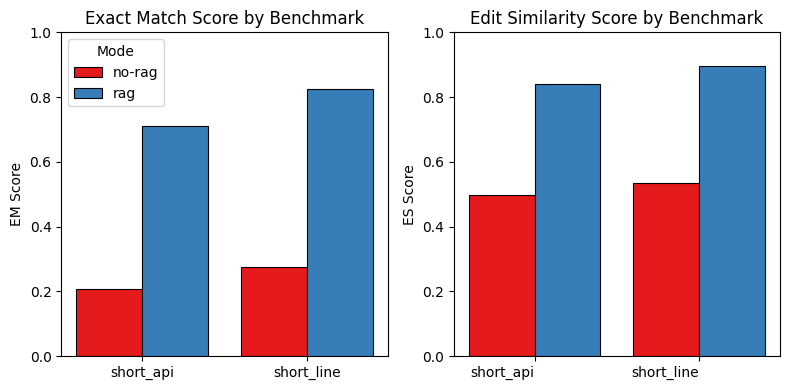

,benchmark,mode,em_score_mean,es_score_mean
0,short_api,no-rag,0.206250,0.498225
1,short_api,rag,0.711875,0.840168
2,short_line,no-rag,0.275000,0.533583
3,short_line,rag,0.825000,0.894706


,benchmark,mode,em_score_mean,es_score_mean
0,short_api,no-rag,0.206250,0.498225
1,short_api,rag,0.711875,0.840168
2,short_line,no-rag,0.275000,0.533583
3,short_line,rag,0.825000,0.894706


In [63]:
plot_repo_metrics(full_df)
plot_agg_metrics(full_df)